# Neural Networks In Depth
<br>
In the last tutorial, we briefly explored Neural Networks and implemented a basic feed forward method for a single hidden layered neural network. Using the same dataset for this tutorial, we will implement a neural network's cost function as well as the algorithm which fits the $\Theta$ weight values that minimize the cost function (called *back propogation*). Let's start off with visualizing the data again.

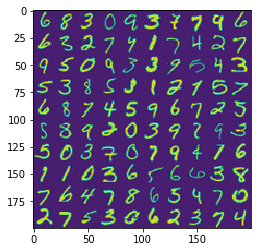

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.optimize import fmin_tnc
import random
import math

data = scipy.io.loadmat('ex4data1.mat')
Y_data = data["y"]

X = random.sample(list(data['X']),100)

def visualizeDigits(X):
    bigImg = np.zeros((200,200))
    
    xIndex = 0
    yIndex = 0
    
    for x in X:
        if xIndex == 200:
            yIndex += 20
            xIndex = 0
        img = np.reshape(x, (20,20)).T
        bigImg[xIndex:xIndex+20,yIndex:yIndex+20] = img
        xIndex += 20
    plt.imshow(bigImg)
    plt.show()
    return

visualizeDigits(X)

When working with neural networks, we have to convert each label in y to be a row vector. These row vectors will have a number 1 at the index which matches the label value and 0s everywhere else. For example, if the label was `6`, the row vector will be `[0,0,0,0,0,1,0,0,0,0]`, if the label was `9`, the row vector will be `[0,0,0,0,0,0,0,0,1,0]` and if the label was `0` the row vector will be `[0,0,0,0,0,0,0,0,0,1]` (due to 0 corresponding with index 9 in this assignment). This is known as *one-hot encoding*.

In [7]:
# note need to subtract 1 from each label in Y_data
y_sub1 = np.vectorize(lambda x: x-1)(Y_data)
y_flip = y_sub1.T[0]

yMatrix = np.eye(10)[y_flip] # creates 10x10 identity matrix and indexes rows based on y_flip
print("Y original:\n", Y_data,"\nShape: ", Y_data.shape, "\n")
print("Y one-hot encoded:\n", yMatrix, "\nShape: ", yMatrix.shape)

Y original:
 [[10]
 [10]
 [10]
 ..., 
 [ 9]
 [ 9]
 [ 9]] 
Shape:  (5000, 1) 

Y one-hot encoded:
 [[ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 ..., 
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]] 
Shape:  (5000, 10)


Cool, now onto the backpropogation algorithm. The first step in backpropogation is to feed forward. We will use theta weights provided by the `ex4weights.mat` file to do so. Note that this feed forward implementation is very similar to the `predict` method in the last tutorial except we return all the intermediate variables (`a1`, `z2`, `a2`, etc) in a dictionary since we need them for later steps in backpropogation.

In [9]:
# add bias column to X
X_data = np.insert(data["X"], 0, 1, axis=1)

thetas = scipy.io.loadmat("ex4weights.mat")
theta1 = thetas["Theta1"]
theta2 = thetas["Theta2"]
print("Theta1:\n", theta1, "\nShape: ", theta1.shape, "\n")
print("Theta2:\n", theta2, "\nShape: ", theta2.shape, "\n")

def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

def feedForward(theta1, theta2, X):
    theta1 = np.matrix(theta1)
    theta2 = np.matrix(theta2)
    
    a1 = X # (5000,401)
    
    z2 = a1 * theta1.T # (5000,401) x (401,25) -> (5000,25)
    a2 = np.insert(sigmoid(z2), 0, 1, axis=1) # sigmoid and add bias column, (5000,26)
    
    z3 = a2 * theta2.T # (5000,26) x (26,10) -> (5000,10)
    a3 = sigmoid(z3) # (5000,10)
    
    return {"a3": a3,
            "a2": a2,
            "a1": a1,
            "z2": z2,
            "z3": z3}

feedForwardVar = feedForward(theta1,theta2,X_data)

print("\na3:\n", feedForwardVar["a3"], "\nShape: ", feedForwardVar["a3"].shape)

Theta1:
 [[ -2.25623899e-02  -1.05624163e-08   2.19414684e-09 ...,  -1.30529929e-05
   -5.04175101e-06   2.80464449e-09]
 [ -9.83811294e-02   7.66168682e-09  -9.75873689e-09 ...,  -5.60134007e-05
    2.00940969e-07   3.54422854e-09]
 [  1.16156052e-01  -8.77654466e-09   8.16037764e-09 ...,  -1.20951657e-04
   -2.33669661e-06  -7.50668099e-09]
 ..., 
 [ -1.83220638e-01  -8.89272060e-09  -9.81968100e-09 ...,   2.35311186e-05
   -3.25484493e-06   9.02499060e-09]
 [ -7.02096331e-01   3.05178374e-10   2.56061008e-09 ...,  -8.61759744e-04
    9.43449909e-05   3.83761998e-09]
 [ -3.50933229e-01   8.85876862e-09  -6.57515140e-10 ...,  -1.80365926e-06
   -8.14464807e-06   8.79454531e-09]] 
Shape:  (25, 401) 

Theta2:
 [[-0.76100352 -1.21244498 -0.10187131 -2.36850085 -1.05778129 -2.20823629
   0.56383834  1.21105294  2.21030997  0.44456156 -1.18244872  1.04289112
  -1.60558756  1.30419943  1.37175046  1.74825095 -0.23365648 -1.52014483
   1.15324176  0.10368082 -0.37207719 -0.61530019 -0.125683

Now that we finished feed forward and kept track of our intermediate variables, we can move onto the next step in backprop, which is the neural network cost function!

The regularized cost function is represented by:
$$
J(\Theta) = - \frac{1}{m} \sum_{i=1}^m \sum_{k=1}^K[y_k^{(i)}\log((h_\theta(x^{(i)}))_k) + (1-y_k^{(i)})\log(1-(h_\theta(x^{(i)}))_k)] + \frac{\lambda}{2m} \sum_{l=1}^{L-1}\sum_{i=1}^{s_l} \sum_{j=1}^{s_{l+1}} (\Theta_{j,i}^{(l)})^2
$$

The equation looks very scary so I am going to try and break it down:

- *m* is the number of training examples, which is 5000 in this assignment.
- *K* is the number of labels, which is 10 in this assignment (labels range from 1-10).
- *L* is the number of layers in our neural network, which is 3 in this assignment.
- $s_l$ is the number of units (not counting bias layer) in layer *l*. $s_1 = 400$, $s_2 = 25$ and $s_3 = 10$ in this assignment.
- $y_k^{(i)}$ refers to the *k*-th element in *i*-th row vector of *y*. Recall that *y* is one-hot encoded 5000x10 matrix. Thus for example, $y_{10}^{(1)} = 1$ and $y_1^{(1)}, ... , y_9^{(1)} = 0$. Note that $y_k^{(i)}$ will always be either 0 or 1.
- $(h_\theta(x^{(i)}))_k$ is the *k*-th element in the *i*-th row vector of $a^{(L)}$, which is $a^{(3)}$ in this assignment. Thus for example, $(h_\theta(x^{(2)}))_1 = (a^{(3)})^{(2)}_1 = 4.79026796e-04$.

The first double sum term in the cost function equation means to sum all the logistic regression costs for each element in $a^{(3)}$ with respect to the corresponding element in *y* (note both $a^{(3)}$ and *y* are 5000x10 matrices). Then multiply the sum by $\frac{-1}{m}$. This will return a real number. 

The second triple sum term means to square every element in each theta (Theta1 and Theta2 in our case) and sum all the squared elements **except for the bias layer - leave that out**. Then multiply the sum by $\frac{\lambda}{2m}$. This will also return a real number. Remember that overall the cost function will return a real number.

Okay time to implement the cost function using vectorization!

In [10]:
theta1unroll = np.ravel(theta1) # unrolls theta1 to be a vector, see below commentary
theta2unroll = np.ravel(theta2)

input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10 # 10 labels, from 1 to 10
nn_params = np.concatenate((theta1unroll, theta2unroll),axis=0)

def nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                  num_labels, X, y, lamda):
    
    # extract theta1 and theta2 as matrices
    theta1 = np.reshape(nn_params[:(input_layer_size + 1) * hidden_layer_size],
                        (hidden_layer_size, input_layer_size + 1))
    
    theta2 = np.reshape(nn_params[(input_layer_size + 1) * hidden_layer_size:],
                        (num_labels, hidden_layer_size + 1))
    
    a3 = np.matrix(feedForward(theta1,theta2,X)["a3"])
    y = np.matrix(y)
    m = X.shape[0]
    
    # there is a proof that for any matrix X,Y of size m by n,
    # sum of entry-wide products is equal to tr(X.T * Y)
    firstTerm = np.trace(-y.T * np.log(a3))
    secondTerm = np.trace((1-y.T) * np.log(1-a3))
    
    cost = (firstTerm - secondTerm)/m
    
    # for regularization, remove bias (first) column from each theta
    theta1_forReg = theta1[:,1:] # select all rows, select all columns from index 1 onwards
    theta2_forReg = theta2[:,1:]
    
    regTerm = (lamda / (2 * m)) * (np.sum(np.square(theta1_forReg)) + np.sum(np.square(theta2_forReg)))
    
    return cost + regTerm

costNoReg = nnCostFunction(nn_params,input_layer_size,hidden_layer_size,
                           num_labels, X_data, yMatrix, 0)
print("No regularization: " + str(costNoReg))

No regularization: 0.287629165161


Nice! The cost matches the expect result as indicated on the assignment. 

An important thing to note while working with neural networks is that $\Theta$ is a *matrix*. Contrast this to linear and logistic regression in which $\Theta$ is a *vector*. Notice in the code above that we have "unrolled" `theta1` and `theta2` to from being a matrix to be very long vector. This is because later on we will be using advanced optimization methods to find the `theta1` and `theta2` weights that minimize the cost function. However, those methods don't know how to work with matrices for they only accept vectors as parameters. Therefore we must unroll `theta1` and `theta2` to be a long vector to feed into the optimization algorithm and subsequently reshape the vector once we want to convert it back to be a set of matrices.

The following cell will check the cost for a few regularization parameters, which match the expected costs indcated on the assignment.

In [12]:
costWithReg1 = nnCostFunction(nn_params,input_layer_size,hidden_layer_size,
                      num_labels, X_data, yMatrix, 1)
costWithReg3 = nnCostFunction(nn_params,input_layer_size,hidden_layer_size,
                      num_labels, X_data, yMatrix, 3)

print("Regularization parameter = 1: " + str(costWithReg1))
print("Regularization parameter = 3: " + str(costWithReg3))

Regularization parameter = 1: 0.383769859091
Regularization parameter = 3: 0.57605124695


The last ingredient we need before we implement backprop is to compute the sigmoid gradient value. It is given by the equation:
$$
g'(z) = g(z)(1-g(z))~~ where ~~g(z) = \frac{1}{1+e^{-z}}
$$

We check that g'(0) should return 0.25.

In [14]:
def sigmoidGradient(z):
    firstTerm = 1 / (1 + np.exp(-z))
    secondTerm = 1 - firstTerm
    return np.multiply(firstTerm, secondTerm)

sigmoidGradient(0)

0.25

Okay ready to implement backpropogation now. It is an algorithm that requires some time to get intuitively (that I struggle with also). Both the Coursera tutorial and the assignment pdf describes in-depth of how implement this algorithm, which I highly recommend following. The following is my implemention following the instructions from the Coursera tutorial.

Note that `backprop` returns the a **unrolled vector of gradients** of the cost function. In other words, `backprop` is the neural network equivalent of `computeGradient`, which we used for linear and logisitc regression in previous tutorials. Also note that when computing the regularization term, we **do not** take the bias column in consideration.

In [15]:
nn_params = np.concatenate((theta1unroll, theta2unroll),axis=0)

def backprop(nn_params, input_layer_size, hidden_layer_size,
                               num_labels, X, y, lamda):
    '''
    First few lines are copy and pasted from nnCostFunction
    '''
    # extract theta1 and theta2, remember to make a copy! 
    # (read up on Python mutable vs immutable datatypes if curious)
    theta1 = np.copy(np.reshape(nn_params[:(input_layer_size + 1) * hidden_layer_size],
                        (hidden_layer_size, input_layer_size + 1)))
    
    theta2 = np.copy(np.reshape(nn_params[(input_layer_size + 1) * hidden_layer_size:],
                        (num_labels, hidden_layer_size + 1)))
    
    # get a3
    feedForwardDict = feedForward(theta1,theta2,X)
    a3 = np.matrix(feedForwardDict["a3"])
    y = np.matrix(y)
    m = X.shape[0]
    
    d3 = a3 - y # 5000x10
    
    # remove bias column from theta2 to calculate d2
    theta2NoBias = theta2[:,1:] # 10x25
    z2 = np.matrix(feedForwardDict["z2"]) # 5000x25
    gPrime2 = sigmoidGradient(z2)
    d2 = np.multiply(d3*theta2NoBias,gPrime2) # 5000x25
    
    # calulating Deltas
    a1 = np.matrix(feedForwardDict["a1"]) # 5000x401
    Delta1 = d2.T * a1 # 25x401

    a2 = np.matrix(feedForwardDict["a2"]) # 5000x26
    Delta2 = d3.T * a2 # 10x26

    # regularization
    
    theta1[:,0] = 0 # don't want to include bias units for regularization
    theta2[:,0] = 0 
    
    Theta1ForReg = (lamda/m) * theta1
    Theta2ForReg = (lamda/m) * theta2
    
    Theta1_grad = (Delta1 / m) + Theta1ForReg
    Theta2_grad = (Delta2 / m) + Theta2ForReg
    
    # unroll again
    gradientVec = np.concatenate((np.ravel(Theta1_grad), np.ravel(Theta2_grad)), axis=0)
    return gradientVec

Now that we finished the backpropogation algorithm, it would be great to check whether the computed gradients are reasonable. To do so, we will use a strategy called **gradient checking**. The idea is that we can approximate gradients of the cost function through the following formula:

$$
\frac{\partial}{\partial \Theta_j} J(\Theta) \approx \frac{J(\Theta_1,...,\Theta_j + \epsilon, ...,\Theta_n) - J(\Theta_1,...,\Theta_j - \epsilon, ...,\Theta_n)}{2\epsilon}
$$

for a small $\epsilon$ (for example, $\epsilon = 0.0001$) and for $1 \leq j \leq n$, where *n* is the number of elements in the gradient vector.

In [24]:
def gradientCheck(nn_params,input_layer_size,hidden_layer_size,num_labels,X,y,lamda):

    # note that backprop returns a VECTOR of gradients
    # whereas nnCostFunction returns a NUMBER
    
    n = len(nn_params)
    epsilon = 0.0001
    gradApprox = []
    for j in range(n):
        thetaPlus = np.copy(nn_params)
        thetaPlus[j] += epsilon
        thetaMinus = np.copy(nn_params)
        thetaMinus[j] -= epsilon
        thetaPlusCost = nnCostFunction(thetaPlus,input_layer_size,hidden_layer_size,num_labels,X,y,lamda)
        thetaMinusCost = nnCostFunction(thetaMinus,input_layer_size,hidden_layer_size,num_labels,X,y,lamda)
        gradApprox.append((thetaPlusCost - thetaMinusCost) / (2*epsilon))
    return gradApprox

Cool! Now let's do gradient checking for gradients computed with regularization parameter = 0 and 1. Note that gradient checking is a **very** slow process, so once we check that the gradient values are reasonable once or twice, we refraining from including it in the actual optimization process.

In [21]:
nn_params = np.concatenate((theta1unroll, theta2unroll),axis=0) # unrolled theta

gradientVec_Reg0 = backprop(nn_params,input_layer_size,hidden_layer_size,
                           num_labels, X_data, yMatrix, 0)
numericalGradient_Reg0 = gradientCheck(nn_params,input_layer_size,hidden_layer_size,
                           num_labels, X_data, yMatrix, 0)

# compare our computed gradient and approximate gradient
d = {
    "Computed": gradientVec_Reg0,
    "Approximate": numericalGradient_Reg0
    }

df = pd.DataFrame(d)
df

,Approximate,Computed
0,6.187128e-05,6.187128e-05
1,0.000000e+00,0.000000e+00
2,0.000000e+00,0.000000e+00
3,4.153622e-09,4.153369e-09
4,-5.298650e-08,-5.298688e-08
5,1.421846e-07,1.421843e-07
6,1.597153e-06,1.597153e-06
7,-8.899995e-07,-8.899996e-07
8,-1.455130e-06,-1.455131e-06
9,-4.089534e-07,-4.089535e-07


In [22]:
nn_params = np.concatenate((theta1unroll, theta2unroll),axis=0) # unrolled theta

gradientVec_Reg1 = backprop(nn_params,input_layer_size,hidden_layer_size,
                           num_labels, X_data, yMatrix, 1)
numericalGradient_Reg1 = gradientCheck(nn_params,input_layer_size,hidden_layer_size,
                           num_labels, X_data, yMatrix, 1)

# compare our computed gradient and approximate gradient
d2 = {
    "Computed": gradientVec_Reg1,
    "Approximate": numericalGradient_Reg1
    }

df2 = pd.DataFrame(d2)
df2

,Approximate,Computed
0,6.187128e-05,6.187128e-05
1,-2.220446e-12,-2.112483e-12
2,2.775558e-13,4.388294e-13
3,2.769174e-09,2.768922e-09
4,-3.522099e-08,-3.522130e-08
5,9.363760e-08,9.363715e-08
6,1.055238e-06,1.055238e-06
7,-5.984852e-07,-5.984852e-07
8,-9.630777e-07,-9.630779e-07
9,-2.662273e-07,-2.662276e-07


Our gradient checks look good for $\lambda = 0$ and $\lambda = 1$. To finally put everything together, let's randomly initialize our $\Theta_1$ and $\Theta_2$ values to be between [-0.12, 0.12] instead of relying on $\Theta_1$ and $\Theta_2$ given to us through the "ex4weights.mat" file.

In [39]:
# randomly initialize weights to small values
epilson_init = 0.12
randTheta1 = np.random.rand(hidden_layer_size, 1 + input_layer_size) * (2 * epilson_init) - epilson_init
randTheta2 = np.random.rand(num_labels, 1 + hidden_layer_size) * (2 * epilson_init) - epilson_init
    
print(randTheta1.shape)
print(randTheta2.shape)

rand_nn_params = np.concatenate((np.ravel(randTheta1),np.ravel(randTheta2)), axis=0)

(25, 401)
(10, 26)


We can now use the advanced optimization methods (or gradient descent) with `nnCostFunction`, `backprop`, and `rand_nn_params` as parameters to get our trained $\Theta_1$ and $\Theta_2$ weights! (for regularization parameter = 3 as an example)

In [42]:
minimum = fmin_tnc(func=nnCostFunction, x0=rand_nn_params, fprime=backprop, args=(input_layer_size,hidden_layer_size,
                      num_labels, X_data, yMatrix, 3))

Finally, we reshape the long $\Theta$ vector obtained from `minimum` back into $\Theta_1$ and $\Theta_2$ matrices and reuse some of our old code from last tutorial to get the performance of our predictions.

In [44]:
trainedTheta1 = np.reshape(minimum[0][:hidden_layer_size * (input_layer_size + 1)],
                    (hidden_layer_size, input_layer_size + 1))
trainedTheta2 = np.reshape(minimum[0][hidden_layer_size * (input_layer_size + 1):],
                    (num_labels, hidden_layer_size + 1))

def updateIndices(index):
    return index + 1

def getAccuracy(actual,predicted): # returns accuracy between actual and predicted dataset
    logicalColumn = actual == predicted
    logicalColumn = logicalColumn.astype(int)
    
    m = logicalColumn.shape[0]
    numberCorrect = np.sum(logicalColumn)
    return numberCorrect/m

def predict(theta1,theta2,X): 
    # predicts labels using TRAINED weights theta1, theta2
    # for neural network with 1 hidden layer and gets accuracy
    # of predictions with respect to y_data
    global Y_data
    
    theta1 = np.matrix(theta1)
    theta2 = np.matrix(theta2)
    X = np.matrix(X)
    
    M = sigmoid(X * theta1.T) # 5000x25 matrix
    M = np.insert(M,0,1,axis=1) # 5000x26 matrix
    
    M2 = M * theta2.T # 5000x10 matrix, output layer

    probabilitiesMatrix = sigmoid(M2) # same as before, get index of highest probability
    predicted = np.argmax(probabilitiesMatrix, axis=1)
    predicted = np.vectorize(updateIndices)(predicted)
    accuracy = getAccuracy(Y_data, predicted)
    
    return accuracy

predict(trainedTheta1, trainedTheta2, X_data)

0.9778

Congrats for making through possibly the longest and most difficult assignment in the course! By now you probably have a greater intuition regarding the inner workings of a neural network. In the next tutorial we will dive into one of my favourite subjects in ML, which is analysis of bias vs. variance and learning curves. See you there! :)